In [1]:
import sys
sys.path.append("..")

In [2]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from matplotlib import pyplot as plt

grid_size = 8
grid_shape = (grid_size, grid_size)

env = gym.make(
    "FrozenLake-v1",
    desc=generate_random_map(size=grid_size),
    is_slippery=False,
    render_mode="rgb_array",
)

In [3]:
from mango.utils import plot_grid
from mango.concepts import GridPartitionConcept, Int2CoordConcept

base_concept = Int2CoordConcept(grid_shape)
concepts = [
    GridPartitionConcept(grid_shape, cell_shape=(2, 2)),
    GridPartitionConcept(grid_shape, cell_shape=(4, 4)),
]

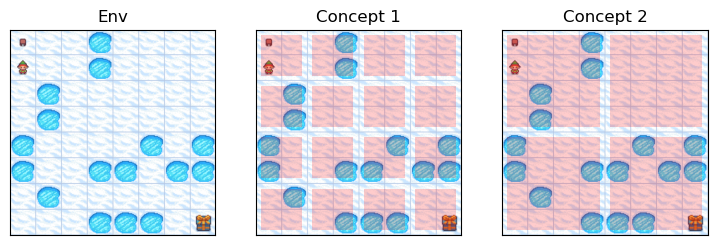

In [17]:
state, info = env.reset()
env.step(1)
img = env.render()


plt.figure(figsize=((1 + len(concepts)) * 3, 3))
for i, concept in enumerate([None] + concepts):
    plt.subplot(1, len(concepts) + 1, 1 + i)
    plt.title("Env" if concept is None else f"Concept {i}")
    plt.imshow(img)  # type: ignore
    if concept is not None:
        plot_grid(grid_shape, concept.cell_shape) # type: ignore
    plt.xticks([])
    plt.yticks([])
plt.show()